In [143]:
%pip install tensorflow==2.15.0
%pip install scikit-learn
%pip install pandas
%pip install numpy
%pip install seaborn
%pip install matplotlib
%pip install wordcloud
%pip install nltk

  Using cached tensorflow-2.15.0-cp310-cp310-win_amd64.whl (2.1 kB)
  Using cached tensorflow_intel-2.15.0-cp310-cp310-win_amd64.whl (300.9 MB)
  Using cached tensorboard-2.15.2-py3-none-any.whl (5.5 MB)
  Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Rolling back uninstall of tensorboard
  Moving to c:\users\epicr\appdata\roaming\python\python310\scripts\tensorboard.exe
   from C:\Users\epicr\AppData\Local\Temp\pip-uninstall-jwgjcxsl\tensorboard.exe
  Moving to c:\users\epicr\appdata\roaming\python\python310\site-packages\tensorboard-2.17.1.dist-info\
   from C:\Users\epicr\AppData\Roaming\Python\Python310\site-packages\~ensorboard-2.17.1.dist-info
  Moving to

ERROR: Could not install packages due to an OSError: [WinError 2] The system cannot find the file specified: 'c:\\Python310\\Scripts\\tensorboard.exe' -> 'c:\\Python310\\Scripts\\tensorboard.exe.deleteme'



Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.



Note: you may need to restart the kernel to use updated packages.


Load Libraries

In [144]:
# deep learning packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# machine learning packages
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import pickle
import nltk
import re
from nltk.stem import PorterStemmer

# visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud


Load Data

In [145]:
train_data = pd.read_csv("train.txt", header=None, sep=";", names=['Comment', 'Emotion'], encoding='utf-8')

# get the length of each comment and add a new column called "Comment"
train_data['Length'] = [len(x) for x in train_data['Comment']]

In [146]:
# output train_data
train_data

,Comment,Emotion,Length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20
...,...,...,...
16495,My friend surprised me with a visit during a r...,surprise,55
16496,I was amazed when my cousin sent me a surprise...,surprise,59
16497,I found an old photograph of my grandparents i...,surprise,57
16498,I received a random thank-you note from a stra...,surprise,69


In [147]:
# check for duplicates, there is 1
train_data.duplicated().sum()

# drop duplicates
train_data.drop_duplicates(inplace=True) #inplace=True means that the changes are made to the data directly

# check for duplicates again, it's now 0
train_data.duplicated().sum()

0

Training Data Without Duplicates

In [148]:
train_data

,Comment,Emotion,Length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20
...,...,...,...
16460,I found an old concert ticket in a book I hadn...,surprise,64
16462,I opened my phone and saw a message from someo...,surprise,86
16472,I found a childhood drawing hidden inside a bo...,surprise,73
16474,My coworker surprised me with tickets to a gam...,surprise,75


In [149]:
# get the count of each emotion
train_data['Emotion'].value_counts()

Emotion
joy         5361
sadness     4666
anger       2159
fear        1937
love        1304
surprise     978
Name: count, dtype: int64

<Axes: xlabel='Emotion', ylabel='count'>

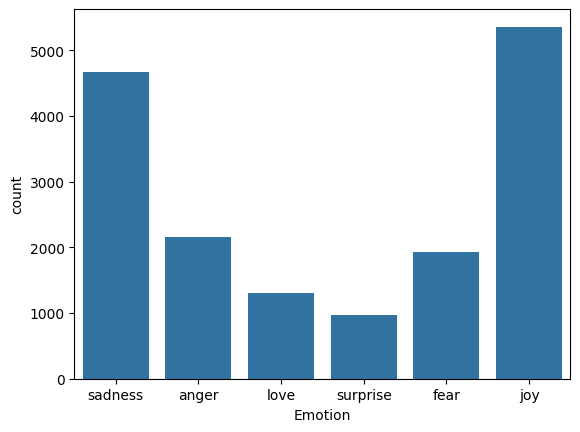

In [150]:
sns.countplot(x = train_data['Emotion'])

# we can see the data is inbalanced

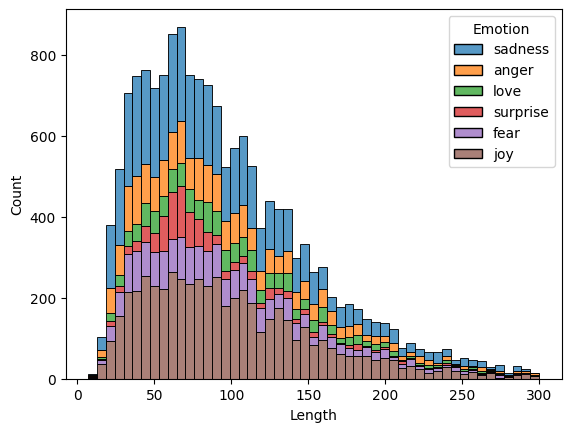

In [151]:
# we can plot length of comments against count with emotion
df2 = train_data.copy()

# convert length column to a numpy array
length_values = df2['Length'].values

# use sns.histplot to plot the length of comments against count with emotion
sns.histplot(data=df2, x='Length', hue='Emotion', multiple='stack')

plt.show()

Emotion Word Clouds - To visually describe frequency of words associated with emotion

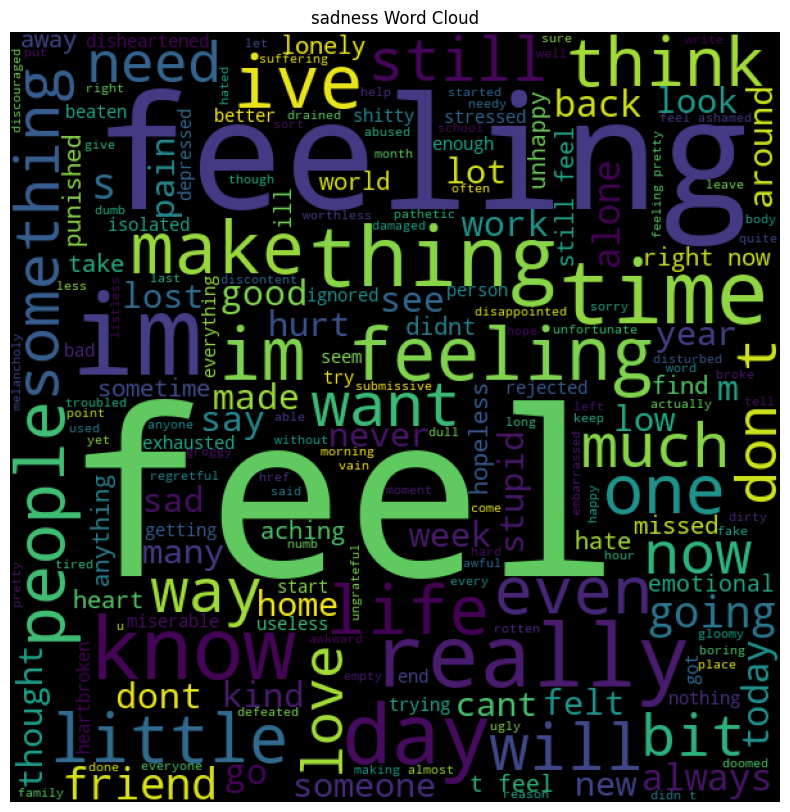

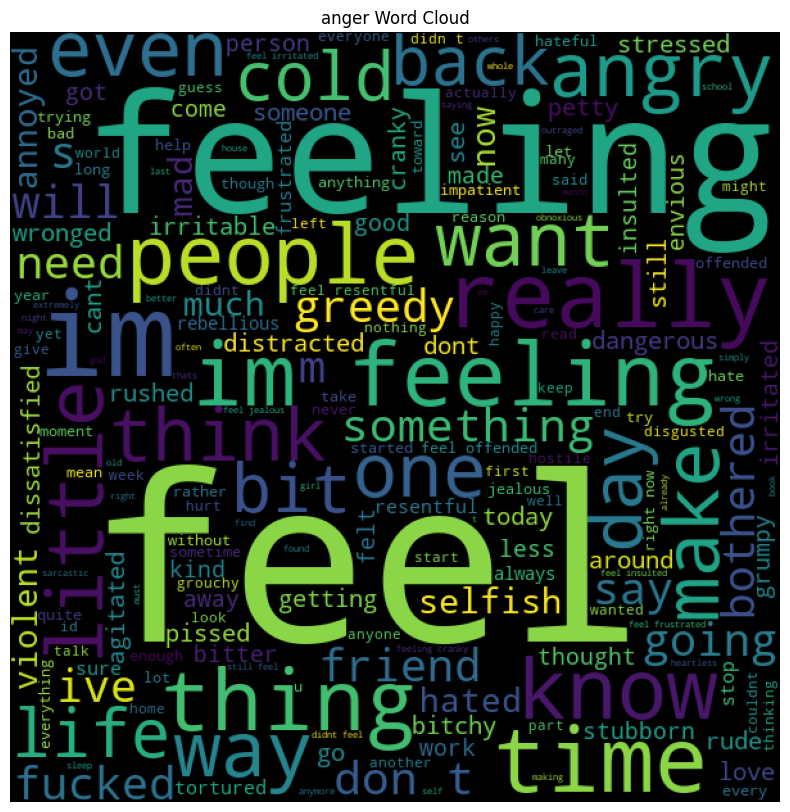

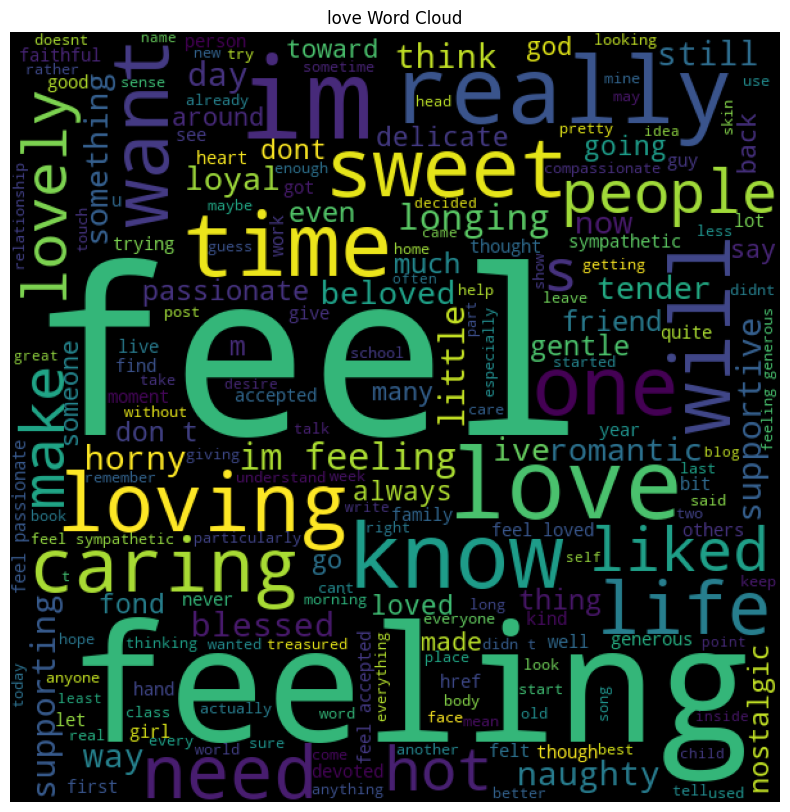

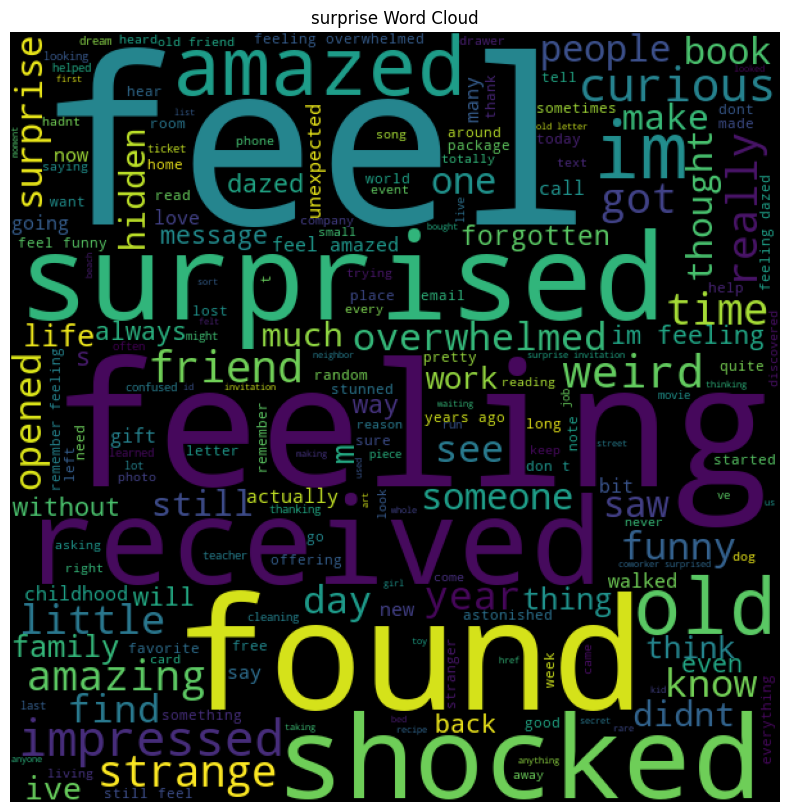

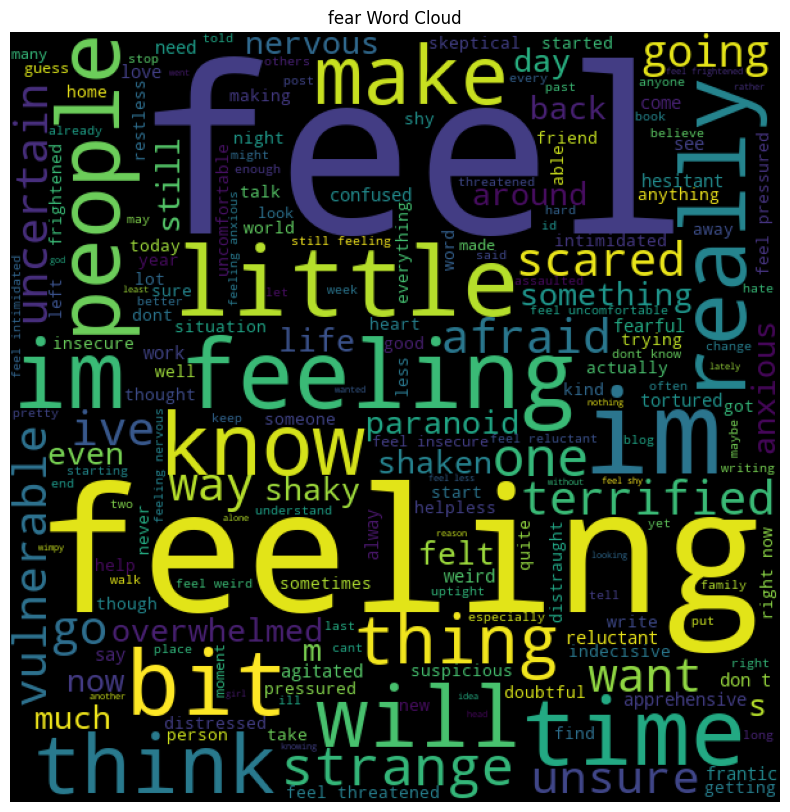

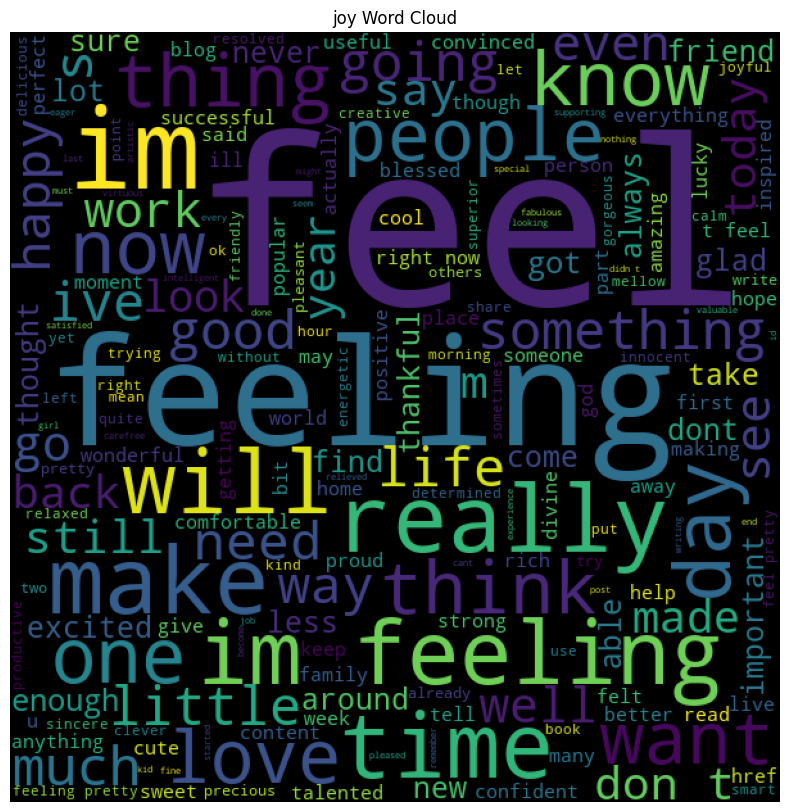

In [152]:
# since we are creating word clouds for each emotion, we can create a function to do this repetitive process

def words_cloud(wordcloud, emotion_name):
  plt.figure(figsize=(10,10))
  plt.title(emotion_name + " Word Cloud")
  plt.imshow(wordcloud)
  plt.axis('off')

# get the emotions
emotions_list = train_data['Emotion'].unique()

# for each emotion, get the sentences where the current emotion column equals the emotion we are iterating through
# Create the wordcloud. In a wordcloud, common words are excluded (e.g. "the", "and", "is", etc.) and more meaningful words are emphasized.
for emotion in emotions_list:
  text = " ".join([sentence for sentence in train_data.loc[train_data['Emotion'] == emotion, 'Comment']])
  wordcloud = WordCloud(width=600, height=600).generate(text)
  words_cloud(wordcloud, emotion)

# Data Preprocessing

First thing we should do is encode the emotions. The machine won't understand what "sadness" or "joy" means. Machines understand numbers, so we need to convert them to numeric values.

In [153]:
lb = LabelEncoder() # this is from sklearn.preprocessing
train_data['Emotion Encoded'] = lb.fit_transform(train_data['Emotion']) # fit_transform does 2 things, fit() learns the unique categories(labels) and transform() converts them into numeric values
train_data

'''
  Anger = 0
  Fear = 1
  Joy = 2
  Love = 3
  Sadness = 4
'''

'\n  Anger = 0\n  Fear = 1\n  Joy = 2\n  Love = 3\n  Sadness = 4\n'

## Applying Machine Learning

In [154]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

### Data cleaning and preprocessing

In [155]:
df = train_data.copy() # don't want to modify the original data

First thing we should do is get rid of stop words. Stop words are words that have no/very little influence on the deducted emotion of the sentence. We can use NLTK's stopwords

In [156]:
stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords.add('feel')
stopwords.add('feeling')

'''
  Cleans the text.
  1. Removes all non-alphabetic characters
  2. Converts the text to lowercase
  3. Splits the text into words
  4. Stems the words, which means it reduces the words to their root form
'''
def clean_text(text):
  stemmer = PorterStemmer()
  text = re.sub("[^a-zA-Z]", ' ', text)
  text = text.lower()
  text = text.split()
  text = [stemmer.stem(word) for word in text if word not in stopwords]
  return " ".join(text)

# res = clean_text("I am 23432 % loving hating, hated, loved") # output : "love hate hate love"
df['Cleaned Comment'] = train_data['Comment'].apply(clean_text)

In [157]:
df

,Comment,Emotion,Length,Emotion Encoded,Cleaned Comment
0,i didnt feel humiliated,sadness,23,4,didnt humili
1,i can go from feeling so hopeless to so damned...,sadness,108,4,go hopeless damn hope around someon care awak
2,im grabbing a minute to post i feel greedy wrong,anger,48,0,im grab minut post greedi wrong
3,i am ever feeling nostalgic about the fireplac...,love,92,3,ever nostalg fireplac know still properti
4,i am feeling grouchy,anger,20,0,grouchi
...,...,...,...,...,...
16460,I found an old concert ticket in a book I hadn...,surprise,64,5,found old concert ticket book open year
16462,I opened my phone and saw a message from someo...,surprise,86,5,open phone saw messag someon thought lost touc...
16472,I found a childhood drawing hidden inside a bo...,surprise,73,5,found childhood draw hidden insid book open year
16474,My coworker surprised me with tickets to a gam...,surprise,75,5,cowork surpris ticket game want attend


We should give important words higher rankings

### Train Test Split

The goal of a machine learning model is to generalize unseen data well, not just the data that it was trained on. Splitting the data into training and testing can help assess how well the model performs on data it hasn't seen yet.

We shouldn't train and test on the same data otherwise the ml model might just be memorizing the data rather than learning to create new patterns.

(X) is input features (independent variables) and (y) is target labels (dependent variables)

In [158]:
# 20% of the data will be used for testing, 80% for training
X_train, X_test, y_train, y_test = train_test_split(df['Cleaned Comment'], df['Emotion Encoded'], test_size=0.2, random_state=42)

### TFDIF Vectorization

TFDIF (Term Frequency Document Inverse Frequency) reflects the importance of a word in a document (document is essentially just a sentence)

Term Frequency - number of times a word appears in a document DIVIDED BY total # of words in the document
  ex. "text processing is necessary" Text TF = 1/4

Inverse Document Frequency - measures the importance of a term across a collection of documents
  - log of the total number of documents DIVIDED BY # of documents that contain the word
  - the rarer the word, the higher the IDF score
  ex. if word is text and the only document is the one above, then its log(1/1) = 0

TFDIF = TF * IDF
  ex. 1/4 * 0 = 0

In [159]:
# Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tdidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tdidf = tfidf_vectorizer.transform(X_test)

these are ml classifiers, which are algorithms used to classify the data into different categories
- Multinomial Naive Bayes - suited for text classification and word counts, it uses the frequency of words to predict the category
- Logistic Regression - models relationship between input features and output; it estimates the probability that a given input belongs to a certain category; used for binary classification
- Random Forest Classifier - Learning method that builds a collection("forest") of decision trees, each tree is trained on random subset of data
  - final decision is made by aggregating the decisions of the individual trees. useful for classification and regression
- Support Vector Classifier - finds a hyperplane that best divides a dataset into classes; it is a supervised learning model with associated learning algorithms that analyze data for classification and regression analysis


In [160]:
classifiers = {
  "Multinomial Naive Bayes": MultinomialNB(),
  "Logistic Regression": LogisticRegression(),
  "Random Forest Classifier": RandomForestClassifier(),
  "Support Vector Classifier": SVC()
}

for name, classifier in classifiers.items():
  print(f"Training {name}...")
  classifier.fit(X_train_tdidf, y_train)
  y_pred_tfidf = classifier.predict(X_test_tdidf)
  accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf) # compares the predicted labels with the actual labels
  print(f"{name} Accuracy using TF-IDF: {accuracy_tfidf}")
  print("Classification Report:")
  print(classification_report(y_test, y_pred_tfidf))

Training Multinomial Naive Bayes...
Multinomial Naive Bayes Accuracy using TF-IDF: 0.6522401706796709
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.33      0.49       424
           1       0.87      0.24      0.37       379
           2       0.57      0.97      0.72      1044
           3       1.00      0.06      0.11       282
           4       0.70      0.89      0.78       948
           5       0.98      0.20      0.33       204

    accuracy                           0.65      3281
   macro avg       0.84      0.45      0.47      3281
weighted avg       0.75      0.65      0.59      3281

Training Logistic Regression...
Logistic Regression Accuracy using TF-IDF: 0.8290155440414507
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.78      0.83       424
           1       0.86      0.72      0.78       379
           2       0.78      0.93      0.85      104

Accuracy - out of n test samples, how many were predicted correctly
Precision - measures how many of the predicted positive cases for each class (emotion) were actually correct (measure of quality)
Recall - measures how many of the actual positive cases for each class were correctly predicted (measure of quantity)
F1-Score - a single score that balances both precision and recall, useful when there is an inbalance between the two
Support - number of true instances for each class in the test set (i.e. the number of samples per class)
Macro-average - calculates the average of precision, recall, and f1-score across all classes equally, without taking class frequency into account
Weighted-average - takes into account the support when calculating the average. Gives weight to classes with more samples

Case 1: High precision and low recall
  - model is very selective and cautious; when it classifies something as positive it's usually correct but misses lots of actual positives

Case 2: High recall but low precision
  - very inclusive, catches most positives, but also makes many incorrect positive predictions

In [161]:
# selecting model
lg = LogisticRegression()
lg.fit(X_train_tdidf, y_train)
lg_y_pred = lg.predict(X_test_tdidf)

In [162]:
def predict_emotion(input_text):
    cleaned_text = clean_text(input_text)
    input_vectorized = tfidf_vectorizer.transform([cleaned_text])

    # Predict emotion
    predicted_label = lg.predict(input_vectorized)[0]
    predicted_emotion = lb.inverse_transform([predicted_label])[0]
    label =  np.max(lg.predict(input_vectorized))

    return predicted_emotion,label

# Example usage 
sentences = [
            "i didnt feel humiliated",
            "i feel strong and good overall",
            "im grabbing a minute to post i feel greedy wrong",
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring",
            "You made me very crazy",
            "i am ever feeling nostalgic about the fireplace i will know that it is still on the property",
            "i am feeling grouchy",
            "He hates you",
            "Today I felt happy, but I wish I could have done better.",
            "I hate you"
            ]
for sentence in sentences:
    print(sentence)
    pred_emotion, label = predict_emotion(sentence)
    print("Prediction :",pred_emotion)
    print("Label :",label)
    print("================================================================")

i didnt feel humiliated
Prediction : sadness
Label : 4
i feel strong and good overall
Prediction : joy
Label : 2
im grabbing a minute to post i feel greedy wrong
Prediction : anger
Label : 0
He was speechles when he found out he was accepted to this new job
Prediction : surprise
Label : 5
This is outrageous, how can you talk like that?
Prediction : anger
Label : 0
I feel like im all alone in this world
Prediction : sadness
Label : 4
He is really sweet and caring
Prediction : love
Label : 3
You made me very crazy
Prediction : joy
Label : 2
i am ever feeling nostalgic about the fireplace i will know that it is still on the property
Prediction : love
Label : 3
i am feeling grouchy
Prediction : anger
Label : 0
He hates you
Prediction : anger
Label : 0
Today I felt happy, but I wish I could have done better.
Prediction : joy
Label : 2
I hate you
Prediction : anger
Label : 0


In [172]:
# save files
import pickle
pickle.dump(lg, open("logistic_regression.pkl", "wb"))
pickle.dump(lb, open("label_encoder.pkl", "wb"))
pickle.dump(tfidf_vectorizer, open("tfidf_vectorizer.pkl", "wb"))

In [173]:
import sklearn
print(sklearn.__version__)

1.5.2


# Applying Deep Learning using LSTM

In [163]:
train_data

,Comment,Emotion,Length,Emotion Encoded
0,i didnt feel humiliated,sadness,23,4
1,i can go from feeling so hopeless to so damned...,sadness,108,4
2,im grabbing a minute to post i feel greedy wrong,anger,48,0
3,i am ever feeling nostalgic about the fireplac...,love,92,3
4,i am feeling grouchy,anger,20,0
...,...,...,...,...
16460,I found an old concert ticket in a book I hadn...,surprise,64,5
16462,I opened my phone and saw a message from someo...,surprise,86,5
16472,I found a childhood drawing hidden inside a bo...,surprise,73,5
16474,My coworker surprised me with tickets to a gam...,surprise,75,5


RNN(LSTM)

A RNN is NN but with sequential data. In our case, the order of text matters.

LSTM is a type of RNN

In Deep Learning, first thing we should do is encode/vectorize (similar to tfdif vectorization)

We can use one-hot vectorization (one-hot encoding), which is where each unique category is represented as a vector length equal to the number of unique categories. Exactly 1 element in the vector is set to 1, the rest are 0

Ex. "He hates you" --------- He -> 1,0,0    , hates -> 0,1,0    , you -> 0,0,1

Second step would be to add padding, since not all sentences are the same length. we just add another vector of 0's


## Text Cleaning, Encoding, and Padding

In [164]:
stopwords = set(nltk.corpus.stopwords.words('english'))

In [165]:
def clean_text(df, column, vocab_size, max_len):
  stemmer = PorterStemmer()

  # corpus is a list that will contain all the cleaned comments
  corpus = []
  for text in df[column]:
    text = re.sub("[^a-zA-Z]", ' ', text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text =  " ".join(text)

    # use one_hot for vectorization(encoding)
    corpus.append(text)
  one_hot_word = [one_hot(input_text = word, n = vocab_size) for word in corpus]
  # pad_sequences is used to ensure that all sequences in a list have the same length
  pad = pad_sequences(sequences=one_hot_word, maxlen=max_len, padding='pre')
  return pad

x_train = clean_text(train_data, 'Comment', vocab_size=11000, max_len=300)
y_train = to_categorical(train_data['Emotion Encoded'])

## Model Building and Training

In [166]:
model = Sequential() # helps to build the model layer by layer
model.add(Embedding(input_dim=11000, output_dim=300, input_length=300)) # embedding is a way to represent words in a vector form, input_dim is # unique words, output_dim is the size of the vector
model.add(Dropout(0.3)) # dropout is used to prevent overfitting, i.e. to ensure that the model doesn't become too reliant on any particular neurons
model.add(LSTM(128)) # LSTM is a type of RNN that is capable of learning long-term dependencies in sequenctial data (ex. text). 128 is the number of neurons, the more neurons, the more complex the model. this layer is hidden
model.add(Dropout(0.3))
# This is known as a fully connected layer where each neuron is connected to every neuron in the previous layer. Each connection has a weight associated with it.
# 64 is the number of neurons. sigmoid is the activation function, which is to introduce non-linearity and learn more complex patterns. 
# We use sigmoid because it is good for binary classification problems
model.add(Dense(64, activation='sigmoid')) 
model.add(Dropout(0.3))
# the first dense layer is to learn intermediate features, the second dense layer is to learn the final output where the # neurons correspond to the # of classes
model.add(Dense(6, activation='softmax')) # 6 because we have 6 emotions

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # adam is an optimization algorithm, categorical_crossentropy is the loss function for multi-class classification problems
model.fit(x_train, y_train, epochs=10, batch_size=64, verbose=1) # used to train the model, epochs is the number of times the model will see the data, batch_size is the number of samples that will be used to train the model at once

Epoch 1/10


C:\Users\epicr\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


257/257 ━━━━━━━━━━━━━━━━━━━━ 105s 399ms/step - accuracy: 0.2676 - loss: 1.8613
Epoch 2/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 103s 400ms/step - accuracy: 0.4521 - loss: 1.4716
Epoch 3/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 102s 397ms/step - accuracy: 0.7089 - loss: 0.7846
Epoch 4/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 102s 398ms/step - accuracy: 0.8155 - loss: 0.5558
Epoch 5/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 101s 392ms/step - accuracy: 0.9090 - loss: 0.3412
Epoch 6/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 112s 434ms/step - accuracy: 0.9288 - loss: 0.2473
Epoch 7/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 104s 404ms/step - accuracy: 0.9506 - loss: 0.1794
Epoch 8/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 102s 395ms/step - accuracy: 0.9569 - loss: 0.1506
Epoch 9/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 105s 408ms/step - accuracy: 0.9589 - loss: 0.1340
Epoch 10/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 91s 354ms/step - accuracy: 0.9687 - loss: 0.1073


## Predictive System

In [1]:
def sentence_cleaning(sentence):
  stemmer = PorterStemmer()
  corpus = []
  text = re.sub("[^a-zA-Z]", ' ', sentence)
  text = text.lower()
  text = text.split()
  text = [stemmer.stem(w) for w in text if w not in stopwords]
  text = " ".join(text)
  corpus.append(text)

  one_hot_word = [one_hot(input_text = word, n = 11000) for word in corpus]
  pad = pad_sequences(sequences=one_hot_word, maxlen=300, padding='pre')
  return pad

sentences = [
  "I hate people",
  "I wish I could have done better",
  "He is so sweet and caring",
  "i love you"
]

for sentence in sentences:
  clean_sentence = sentence_cleaning(sentence)
  emotion = lb.inverse_transform(np.argmax(model.predict(clean_sentence), axis=-1))[0]
  probability = np.max(model.predict(clean_sentence))
  print(f"Emotion: {emotion}")
  print(f"Label: {probability}")

NameError: name 'PorterStemmer' is not defined

In [171]:
model.save('model.h5')